# DATA

In [1]:
%load_ext autoreload
%autoreload 2
import genericIO
import SepVector
import Hypercube
import numpy as np
import Operator
import time

In [2]:

n1 = 200
n2 = 200 

d1 = 20
d2 = 10

o1 = 0
o2 = 0

s0 = 1/2000

slow = SepVector.getSepVector(Hypercube.hypercube(ns=[n1,n2],ds=[d1,d2],os=[o1,o2]),storage='dataComplex')

slowNd = slow.getNdArray()
slowNd[:].real = s0

In [3]:
import WEM 
import json

ns = 1
par = {
    "ns" : ns,
    "dsx" : 1,
    "osx" : 3000,
    "dsz" : 0,
    "osz" : 50,
    
    "nr" : n1,
    "drx" : d1,
    "orx" : 0,
    "drz" : 0,
    "orz" : (n2-1)*d2,
    
    "fmin" : 1, 
    "fmax" : 15,  
    
    "nref" : 1,
    "tap" : 200,
    "ng" : 3,
    "prop" : 'ssf',
    
    "ntaylor" : 1,
    "onepass" : 1
    
}


ot = 0
tmax = 3
dt = 0.004
nt = int((tmax-ot) / dt)
wave = SepVector.getSepVector(Hypercube.hypercube(ns=[nt],ds=[dt],os=[ot]))
waveNd = wave.getNdArray()
t = np.linspace(ot,tmax,nt) - .5
f0 = 5
waveNd[:] = (1-2*(np.pi*f0*t)**2)* np.exp(-(np.pi*f0*t)**2)
print(waveNd.shape)
# waveNd = np.roll(waveNd,-int(0.5/dt))

data = SepVector.getSepVector(Hypercube.hypercube(ns=[nt,par["nr"],par["nr"]],ds=[dt,par["drx"],par["dsx"]],os=[ot,par["orx"],par["osx"]]))
datNd = data.getNdArray()

parObj = genericIO.pythonParams(par).getCpp()

(750,)


/opt/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


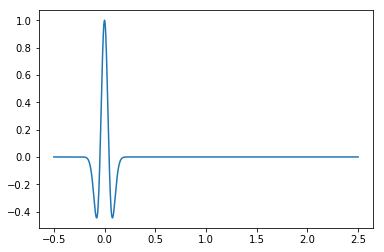

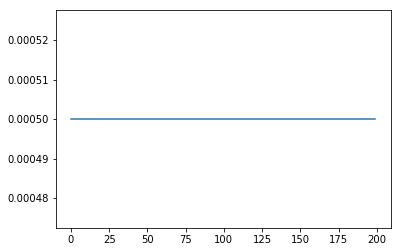

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t,waveNd)

plt.figure()
plt.plot(slowNd[:,0])

In [5]:
import WEM
wem = WEM.WEM(slow,data,wave,parObj)

wem.forward(False,slow,data)


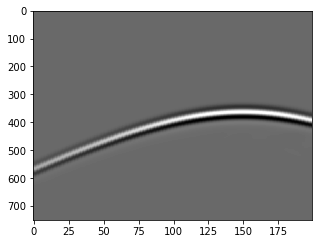

In [6]:
plt.figure(figsize=[5,10])
pclip = .9
which = 0
a_max = pclip*np.amax(datNd[which,:,:])
a_min = pclip*np.amin(datNd[which,:,:])
plt.imshow(np.clip(datNd[which,:,:].T,a_max=a_max, a_min=a_min),cmap='gray',aspect=.2)
plt.show()

# Stat phase approximation

In [7]:
sc = 1
p = np.zeros((sc*n1,sc*nt))
p[int(par["osx"]/d1),:nt] = waveNd
p[int(par["osx"]/d1)-1,:nt] = waveNd*.5
p[int(par["osx"]/d1)+1,:nt] = waveNd*.5
P = np.fft.fft2(p)
# P = np.fft.fftshift(P,axes=0)
dz = par["orz"]

In [8]:
dw = 1/((nt-1)*dt*sc) * 2*np.pi
k = 2*np.pi*np.linspace(-1/(2*d1),1/(2*d1),p.shape[0])
k = np.fft.fftshift(k)
pz = np.zeros(p.shape,dtype=complex)

for it in range(pz.shape[1]):
    t = -.5 + it*dt
    u = t**2-s0**2*dz**2
    if u >=0:
        w0 = t*np.abs(k)/(s0*np.sqrt(u))
        phi0 = -s0*np.abs(k)*dz**2/np.sqrt(u)
        dphi2 = u**(3/2)/(s0*np.abs(k)*dz**2)
        sgn_phi = np.sign(dphi2)
        iw = (w0/dw).astype(int)
        for i1 in range(pz.shape[0]):
            x = i1*d1
            for ik in range(iw.size):
                if np.abs(iw[ik]) < pz.shape[1]:
                    res = np.exp(1j*(phi0[ik]+k[ik]*x + sgn_phi[ik]*np.pi/4)) * np.sqrt(2*np.pi/(t*np.abs(dphi2[ik])))
                    pz[i1,it] += P[ik,iw[ik]]*res*np.exp(1j*w0[ik]*t)*np.exp(1j*.5*w0[ik])
                    pz[i1,it] += P[ik,-iw[ik]]*res*np.exp(-1j*w0[ik]*t)*np.exp(-1j*.5*w0[ik])

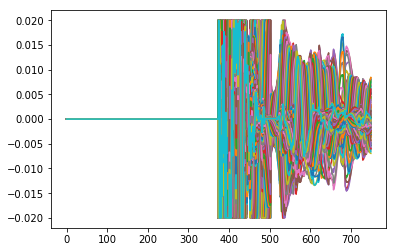

In [9]:
pclip = 50
clip = 0.5*np.amax(pz.real)
pp = np.clip(pz.real/pz.size, a_max=.02, a_min=-.02)
plt.plot(pp.T)

plt.show()

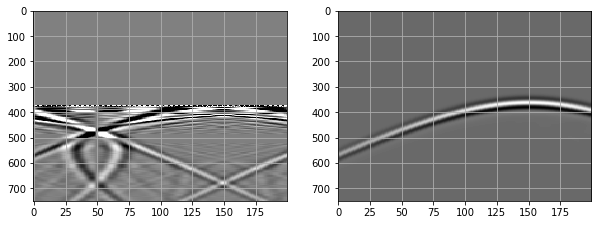

In [10]:

fig, ax = plt.subplots(1,2,figsize=[10,20])
ax[0].imshow(pp.T[:nt,:n1],cmap='gray',aspect=.2)
ax[1].imshow(datNd[0,:].T,cmap='gray',aspect=.2)
ax[0].grid()
ax[1].grid()
plt.show()

## Stat phase 2

In [11]:
p = np.zeros((n1,nt))
p[int(par["osx"]/d1),:] = waveNd
p[int(par["osx"]/d1)-1,:] = waveNd*.5
p[int(par["osx"]/d1)+1,:] = waveNd*.5
P = np.fft.fft2(p)
P = np.fft.fftshift(P)
dz = par["orz"]

In [12]:
# pz = np.zeros(p.shape,dtype=complex)

# w = 2*np.pi*np.linspace(-1/(2*dt),1/(2*dt),nt)
# for iw in range(nt):
#     for ik in range(k.size):
#         kz2 = w[iw]**2 * s0**2 - k[ik]**2
#         if kz2 >=0:
#             kz = np.sqrt(kz2)
#             t = w[iw]*s0**2*dz/kz
#             it = int(t/dt)
#             if it < nt and it >= 0:
#                 phi0 = -dz*kz
#                 dphi2 = k[ik]**2*s0**2*dz**2/kz**3
#                 sgn_phi = np.sign(dphi2)
#                 for i1 in range(n1):
#                     x = i1*d1
#                     res = np.exp(1j*(phi0-k[ik]*x + sgn_phi*np.pi/4)) * np.sqrt(2*np.pi/(t*np.abs(dphi2)))
#                     pz[i1,it] += P[ik,iw]*res*np.exp(1j*w[iw]*t)*np.exp(1j*.5*w[iw])

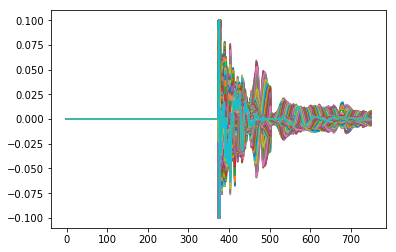

In [13]:
pclip = 50
clip = 0.5*np.amax(pz.real)
pp = np.clip(pz.real/pz.size, a_max=.1, a_min=-.1)
plt.plot(pp.T)

plt.show()

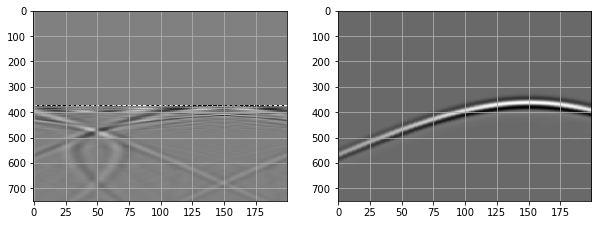

In [14]:

fig, ax = plt.subplots(1,2,figsize=[10,20])
ax[0].imshow(pp.T,cmap='gray',aspect=.2)
ax[1].imshow(datNd[0,:].T,cmap='gray',aspect=.2)
ax[0].grid()
ax[1].grid()
plt.show()